In [2]:
# my imports
import matplotlib.pyplot as plt
import copy
from torch.utils.data import DataLoader

In [3]:
# diffusion paper imports
import numpy as np
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

# Implemented for DPfAV

In [4]:
from helpers.utils import *
from datasets.position_dataset import PositionDataset
from datasets.vel_steering_dataset import VelSteeringDataset


# Diffusion paper implementation

In [5]:
from models.modified_resnet import *
from models.modified_unet import *

# Visualization functions

### Visualization

In [6]:
# visualize poses in first image
def plot_poses_in_image(T_body_front_cam, front_cam_intrinsic, poses, gt_bool=True, color='lime'):
    '''
    param:poses, in cam_front frame
    Plots the poses in the image
    '''
    
    # transform poses to image frame
    poses = [[pose[0], pose[1], 0, 1] for pose in poses]
    time_axis = np.arange(len(poses))
    x_pixel = []
    y_pixel = []
    for _pose in poses:
        if _pose[0] < 0:
            continue
        pose = front_cam_intrinsic @ (T_body_front_cam @ _pose)[:3]
        pose_pixel = pose[:2] / pose[2]
        # check if pixel is in image
        if pose_pixel[0] < 0 or pose_pixel[0] > 1600 or pose_pixel[1] < 0 or pose_pixel[1] > 900:
            print('Pose outside image', _pose)
            continue
        x_pixel.append(pose_pixel[0])
        y_pixel.append(pose_pixel[1])
    if not gt_bool:
        # plot with intensity
        time_axis = np.arange(len(x_pixel))
        plt.scatter(x_pixel, y_pixel, c=time_axis, cmap='magma', s=1)
    else:
        plt.scatter(x_pixel, y_pixel, color=color, s=1)
    

def visualize_sample(batch, dataset, action_type, pred_actions=None, idx=0):
    if pred_actions is None:
        pred_actions = torch.empty_like(batch['action'])
    # unnormalize image
    normalized_tensor_im = batch['image'][0][1]
    unnormalized_tensor_im = image_unnormalizer(normalized_tensor_im)

    if action_type == 'positions':
        unormalized_positions_gt = position_unnormalizer(batch['action'])
        unormalized_positions_pred = position_unnormalizer(pred_actions)
    else:
        unormalized_positions_gt = from_norm_cmds_to_positions(batch['action'])
        unormalized_positions_pred = from_norm_cmds_to_positions(pred_actions)

    # transformations
    T_body_front_cam = dataset.nusc.get_T_body_front_cam(batch['meta_sequence']['sample_token'][0])
    front_cam_intrinsic = dataset.nusc.get_front_cam_intrinsics(batch['meta_sequence']['sample_token'][0])
    
    
    # Convert tensor to a PIL image
    image = transforms.ToPILImage()(unnormalized_tensor_im).resize((1600, 900))
    plt.imshow(image)
    plt.axis('off')
    plt.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=0, color='lime', label='Expert trajectory')
    plt.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=0, color='purple', label='Predicted trajectory')
    plot_poses_in_image(T_body_front_cam,
                         front_cam_intrinsic,
                         unormalized_positions_gt[0], color='lime')
    plot_poses_in_image(T_body_front_cam,
                        front_cam_intrinsic,
                        unormalized_positions_pred[0], gt_bool=False, color='magma')
    plt.imshow(image)
    plt.title(r'Ground truth positions Vs. predicted positions')
    plt.legend(loc='upper right')
    plt.savefig(f'gt_vs_pred_{idx}.pdf')
    plt.show()


def plot_states(states1, states2, idx, action_type, arrow_length=2):
    # need to fix this
    plt.figure()
    plt.axis("equal")

    # Extract x, y, and yaw values for the first set of states
    x1 = [state[1] for state in states1]  # Flip x and y axes
    y1 = [state[0] for state in states1]  # Flip x and y axes
    yaw1 = [state[2] + np.pi / 2 for state in states1]  # Rotate by 90 degrees

    # Extract x, y, and yaw values for the second set of states
    x2 = [state[1] for state in states2]  # Flip x and y axes
    y2 = [state[0] for state in states2]  # Flip x and y axes
   
    yaw2 = [state[2] + np.pi / 2 for state in states2] # Rotate by 90 degrees
    

    # Plot arrows for the first set of states in blue
    plt.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=0, color='lime', label='Expert trajectory')
    for i in range(len(states1)):
        plt.quiver(-x1[i], y1[i], np.cos(yaw1[i])*arrow_length, np.sin(yaw1[i])*arrow_length, angles='xy', scale_units='xy', scale=1, color='lime')

    # Plot arrows for the second set of states in red
    plt.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=0, color='purple', label='Predicted trajectory')
    time_axis = np.arange(len(x2))
    for i in range(len(states2)):
        plt.quiver(-x2[i], y2[i], np.cos(yaw2[i])*arrow_length,
                    np.sin(yaw2[i])*arrow_length, angles='xy', 
                    scale_units='xy', scale=1, color=plt.cm.magma(time_axis[i] / len(time_axis)))

    plt.xlabel(r'$y$')
    plt.ylabel(r'$x$')
    plt.title(r'Position and heading')
    plt.legend(loc='upper right')
    plt.savefig(f'gt_vs_pred_arrows_{idx}.pdf')
    plt.show()

def plot_positions_bird_eye(batch, pred_actions, action_type, idx):
    if action_type == 'positions':
        unormalized_actions_gt = position_unnormalizer(batch['action'])[0]
        unormalized_positions_gt = [[pose[0], pose[1], pose[2], 1] for pose in unormalized_actions_gt]
        unormalized_actions_pred = position_unnormalizer(pred_actions)[0]
        unormalized_positions_pred = [[pose[0], pose[1], pose[2], 1] for pose in unormalized_actions_pred]
    else:
        # velocity and steering angle
        unormalized_positions_gt = from_norm_cmds_to_positions(batch['action'])[0]
        unormalized_positions_pred = from_norm_cmds_to_positions(pred_actions)[0]
        

    plot_states(unormalized_positions_gt, unormalized_positions_pred, idx, action_type)

# Inference

In [7]:
obs_horizon = 2
pred_horizon = 16
action_horizon = 8
print('Loading dataset')
dataset_path = '/cluster/work/simenmsa/nuscenes'
version = 'v1.0-trainval'
action_type = 'vel_steer'
test = True
test_file = 'test_sample_tokens.txt'

if action_type == 'positions':
    # define dimensions
    action_dim = 3
    # agent_pos is 3 dimensional
    lowdim_obs_dim = action_dim
    # define dataset
    dataset = PositionDataset(dataset_path, version, obs_horizon, pred_horizon, action_horizon, test, test_file)
elif action_type == 'vel_steer':
    action_dim = 2
    lowdim_obs_dim = action_dim
    dataset = VelSteeringDataset(dataset_path, version, obs_horizon, pred_horizon, action_horizon, test, test_file)
    
else:
    print('ERROR: non existing action type:', action_type)
    exit()

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
print('Dataset loaded, and contains', len(dataset), 'samples')

print('Constructing model')
# construct ResNet18 encoder
# if you have multiple camera views, use seperate encoder weights for each view.
vision_encoder = get_resnet('resnet18')
# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
vision_encoder = replace_bn_with_gn(vision_encoder)
# ResNet18 has output dim of 512
vision_feature_dim = 512

# observation feature has 514 dims in total per step
obs_dim = vision_feature_dim + lowdim_obs_dim

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)
# the final arch has 2 parts
nets = nn.ModuleDict({
    'vision_encoder': vision_encoder,
    'noise_pred_net': noise_pred_net
})
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
num_train_timesteps=num_diffusion_iters,
# the choise of beta schedule has big impact on performance
# we found squared cosine works the best
beta_schedule='squaredcos_cap_v2',
# clip output to [-1,1] to improve stability
clip_sample=True,
# our network predicts noise (instead of denoised action)
prediction_type='epsilon'
)
# device transfer
device = torch.device('cuda')
_ = nets.to(device)

Loading dataset
File exists
Dataset loaded, and contains 3076 samples
Constructing model
number of parameters: 7.994727e+07


In [8]:
# get bacth sample
batch = next(iter(dataloader))
# visualize sample
print(batch['meta_sequence'].keys())
sample = dataset.nusc.nusc.get('sample', batch['meta_sequence']['sample_token'][0])
print(dataset.nusc.nusc.get('sample_annotation', sample['anns'][0]))


dict_keys(['sample_token', 'T_g_s', 'T_s_g', 'yaw_g_s'])
{'token': 'de098d73a54241f98f48e03664734747', 'sample_token': '07ddc5f1a2db4d2ba0ef71021b4115f2', 'instance_token': 'd178020a715c40e7af3554792625fc81', 'visibility_token': '1', 'attribute_tokens': ['5a655f9751944309a277276b8f473452'], 'translation': [843.555, 1502.106, -0.334], 'size': [0.455, 1.82, 1.284], 'rotation': [-0.6281803596442809, 0.0, 0.0, 0.7780677578188047], 'prev': '2e87135ad7e641db871a733995f74f6b', 'next': '17e5c07e27e44b3e81a9c4269a845e4d', 'num_lidar_pts': 6, 'num_radar_pts': 0, 'category_name': 'vehicle.bicycle'}


In [9]:
load_pretrained = True
if load_pretrained:
  pt_path = "/cluster/work/simenmsa/models/checkpoint_epoch_99.pt"
  
  checkpoint = torch.load(pt_path, map_location='cuda')
  model_state_dict = checkpoint['model_state_dict']  # Access the model's state_dict
  ema_nets = nets
  # Load the state_dict into your model
  ema_nets.load_state_dict(model_state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

Pretrained weights loaded.


In [22]:
from ipywidgets import IntProgress
from IPython.display import display
from time import time
from helpers.evaluator import Evaluator 

evaluator = Evaluator(dataset.nusc.nusc)
# progress bar
f = IntProgress(min=0, max=len(dataset)/dataloader.batch_size) # instantiate the bar
display(f)
saved_figs = 0
# iterate over test set
for batch_idx, data in enumerate(dataloader):
    # already normalized
    images = np.stack(data['image'])
    agent_poses = np.stack(data['agent_pos'])
    images = torch.from_numpy(images).to(device, dtype=torch.float32)
    agent_poses = torch.from_numpy(agent_poses).to(device, dtype=torch.float32)
    with torch.no_grad():
        start_time = time()
        visual_emb = ema_nets['vision_encoder'](images.flatten(end_dim=1))
        visual_features = visual_emb.reshape(*images.shape[:2], -1)
        obs_cond = torch.cat([visual_features, agent_poses], dim=-1).view(images.shape[0], -1)
        noisy_action = torch.randn((images.shape[0], pred_horizon, action_dim), device=device)
        naction = noisy_action

        noise_scheduler.set_timesteps(num_diffusion_iters)
        for k in noise_scheduler.timesteps:
            noise_pred = ema_nets['noise_pred_net'](
                sample=naction,
                timestep=k,
                global_cond=obs_cond)
            
            # invserse diffusion process
            naction = noise_scheduler.step(
                model_output=noise_pred,
                timestep=k,
                sample=naction
            ).prev_sample
            
    naction = naction.detach().cpu()
    # naction has shape (batch_size, pred_horizon, action_dim)
    # if saved_figs < 4:
    #     data_cp = copy.deepcopy(data)
    #     # take only first sample in batch
    #     naction_cp = copy.deepcopy(naction)
    #     plot_positions_bird_eye(data_cp, naction_cp, action_type, saved_figs)
    #     visualize_sample(data_cp, dataset, action_type,  pred_actions=naction_cp, idx=saved_figs)
            
        
    #     saved_figs += 1

    # calculate loss
    if action_type == 'positions':
        # transform to positions
        unormalized_positions_pred = position_unnormalizer(naction)
        unorm_pos_gt = position_unnormalizer(data['action'])
        
    else:
        # transform to positions
        unormalized_positions_pred = from_norm_cmds_to_positions(naction)
        unorm_pos_gt = position_unnormalizer(data['gt_pos'])
        
    # increment progress bar
    for pred, batch in zip(unormalized_positions_pred, unorm_pos_gt):
        pred_cp = copy.deepcopy(pred)
        gt_cp = copy.deepcopy(batch)
        evaluator.calc_metrics(gt_cp, pred_cp, data['meta_sequence']['sample_token'][0],
                               data['meta_sequence']['T_s_g'][0])
    
    f.value += 1
    if f.value == 1:
        break

IntProgress(value=0, max=3076)

In [ ]:
evaluator.save_metrics('vel_steer_l2_collision.txt')

# Serializable visualization

Pose outside image [tensor(4.9230), tensor(0.), 0, 1]
Pose outside image [tensor(5.0302), tensor(-0.4963), 0, 1]
Pose outside image [tensor(19.3694), tensor(-12.6474), 0, 1]
Pose outside image [tensor(19.8480), tensor(-13.3048), 0, 1]
Pose outside image [tensor(20.1286), tensor(-13.7171), 0, 1]
Pose outside image [tensor(19.7409), tensor(-13.0552), 0, 1]
Pose outside image [tensor(21.0516), tensor(-15.7866), 0, 1]
Pose outside image [tensor(21.4821), tensor(-18.1109), 0, 1]
Pose outside image [tensor(19.4885), tensor(-19.2079), 0, 1]
Pose outside image [tensor(16.2615), tensor(-22.9909), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(5.0257), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.9329), tensor(0.), 0, 1]
Pose outside image [tensor(6.1348), tensor(-0.0751), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.9737), tensor(0.), 0, 1]
Pose outside image [tensor(5.2279), tensor(-0.0403), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(5.8581), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(5.3699), tensor(0.), 0, 1]
Pose outside image [tensor(4.4314), tensor(-0.2832), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(5.6991), tensor(0.), 0, 1]
Pose outside image [tensor(5.2259), tensor(-0.0771), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.7665), tensor(0.), 0, 1]
Pose outside image [tensor(6.1496), tensor(-0.7044), 0, 1]
Pose outside image [tensor(20.9400), tensor(-14.2330), 0, 1]
Pose outside image [tensor(23.5410), tensor(-16.7795), 0, 1]
Pose outside image [tensor(24.7312), tensor(-18.5520), 0, 1]
Pose outside image [tensor(24.6030), tensor(-18.3786), 0, 1]
Pose outside image [tensor(24.2580), tensor(-17.9188), 0, 1]
Pose outside image [tensor(24.0352), tensor(-17.6166), 0, 1]
Pose outside image [tensor(26.1004), tensor(-20.0992), 0, 1]
Pose outside image [tensor(25.4807), tensor(-20.2413), 0, 1]
Pose outside image [tensor(21.9562), tensor(-21.3041), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(5.3535), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(5.8713), tensor(0.), 0, 1]
Pose outside image [tensor(24.7188), tensor(-14.4150), 0, 1]
Pose outside image [tensor(24.9292), tensor(-14.7467), 0, 1]
Pose outside image [tensor(25.6941), tensor(-16.7211), 0, 1]
Pose outside image [tensor(25.3544), tensor(-17.0590), 0, 1]
Pose outside image [tensor(24.0910), tensor(-18.4074), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.6818), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.2932), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.4140), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.7093), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.3389), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.1744), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.6370), tensor(0.), 0, 1]
Pose outside image [tensor(29.1739), tensor(19.7066), 0, 1]
Pose outside image [tensor(32.5728), tensor(21.4191), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.9009), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.9901), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.5271), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.8443), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.3633), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.0851), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.3967), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.4559), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.6305), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.3992), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(4.5249), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.7456), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.7192), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.5890), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.7994), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.2968), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.0261), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.1648), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(2.9835), tensor(0.), 0, 1]
Pose outside image [tensor(5.8885), tensor(0.3959), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(2.9537), tensor(0.), 0, 1]
Pose outside image [tensor(5.8885), tensor(0.1888), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.2726), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.2732), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.0763), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.1757), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(2.8041), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.2649), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.0881), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.2180), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.5487), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.4295), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.4627), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


Pose outside image [tensor(3.5585), tensor(0.), 0, 1]


/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/cluster/home/simenmsa/av_diffusion/lib/python3.10/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


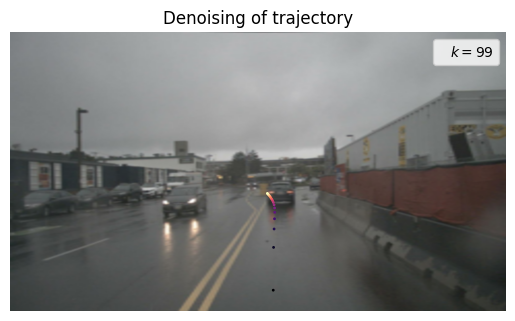

In [21]:
T_body_front_cam = dataset.nusc.get_T_body_front_cam(data['meta_sequence']['sample_token'][0])
front_cam_intrinsic = dataset.nusc.get_front_cam_intrinsics(data['meta_sequence']['sample_token'][0])

normalized_tensor_im = data['image'][0][1]
unnormalized_tensor_im = image_unnormalizer(normalized_tensor_im)
# Convert tensor to a PIL image

for nac_outer in intermediate_naction:

    for j, pred in enumerate(nac_outer):
        if j > 50:
            image = transforms.ToPILImage()(unnormalized_tensor_im).resize((1600, 900))
            pred_cp = copy.deepcopy(pred)
            plt.clf()
            plt.imshow(image)
            plt.axis('off')
            plt.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=0, label=r'$k={}$'.format(j))
            plot_poses_in_image(T_body_front_cam,
                        front_cam_intrinsic,
                        pred_cp[0], gt_bool=False, color='magma')
            plt.imshow(image)
            plt.title(r'Denoising of trajectory')
            plt.legend(loc='upper right', markerscale=0, handlelength=0)
            plt.savefig(f'denoising{j}.pdf')
        #plt.show()
